
**Install requirements**

In [2]:
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging
import copy 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torch.autograd import Function

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.datasets import VisionDataset

from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import random

####**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

DATA_DIR = 'AIML_project_dataset/dataset_3'
NUM_CLASSES = 4 

BATCH_SIZE = 256     # Batch size will be chosen through a grid search
#LR = 1e-3            # Learning rate will be chosen through a grid search

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
#WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

#NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10


####**Define Data Preprocessing**

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
 
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                  # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                  # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean, std)# Normalizes tensor with mean and standard deviation
                                        
])

# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)                                    
])

####**class Quad_Reader**

In [0]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Quad_Reader(VisionDataset):
  def __init__(self, root, split='train', transform=None, target_transform=None, loader=pil_loader):
        super(Quad_Reader, self).__init__(root, transform=transform, target_transform=target_transform)
        
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.classes, self.class_to_idx = self._find_classes(self.root)
        self.images = self.make_dataset(DATA_DIR,self.class_to_idx)

  def _find_classes(self, dir):
        
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

  def make_dataset(self, dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    
    for target in sorted(class_to_idx.keys()):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue
        for root, dirs, _ in sorted(os.walk(d)):
            for i in sorted(dirs):
                path = os.path.join(root, i)
                item = (path, class_to_idx[target])
                images.append(item)

    return images  # contiene i path delle cartelle contenenti le quaterne. Ogni path è associato ad un'etichetta che indica la posizione dell'odd

  def __getitem__(self, index):

        quad = []
        sample_dir, label = self.images[index]
        for img in sorted(os.listdir(sample_dir)):
          image_path = os.path.join(sample_dir, img) 
          quad.append( self.loader(image_path))

        # Applies preprocessing when accessing the image
        if self.transform is not None:
          for i in range(4):
              quad[i] = self.transform(quad[i])
        if self.target_transform is not None:
            label = self.target_transform(label)

        return quad, label  

  def __len__(self):
        length = len(self.images)
        return length  

####**OOONet**

In [0]:
class ConcatLayer(Function):
    @staticmethod
    def forward(ctx, fc6_1 ,fc6_2, fc6_3 ,fc6_4):
        #print(fc6_1.shape,fc6_2.shape,fc6_3.shape,fc6_4.shape )
        concatenation = torch.stack([fc6_1, fc6_2,fc6_3,fc6_4], dim=1) # esempio (3,4) (3,4)  ---> ( 2, 3, 4 )  oppure ( 4096 )( 4096 ) --> (2,4096)
        #print("out concatenation")
        #print(concatenation.shape)
        return concatenation
        
    @staticmethod
    def backward(ctx, grad_output):
        #print("backward concatenation")
        grads = torch.unbind(grad_output,dim=1)
        """for t in grads:
         print(t.shape)"""
        #print(grad_output.shape)
        return grads


class OOONet(nn.Module):

    def __init__(self, num_classes=1000):
        super(OOONet, self).__init__()
        
        self.branch1_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),           
        )
        self.branch1_2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                   #FC 6 
            nn.ReLU(inplace=True),
        )
        self.branch2_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),
        )
        self.branch2_2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                   #FC 6 
            nn.ReLU(inplace=True),
        )
        self.branch3_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),   
        )
        self.branch3_2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                   #FC 6 
            nn.ReLU(inplace=True),
        )
        self.branch4_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  #CONV 5 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6)),
               
        )
        self.branch4_2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),                   #FC 6 
            nn.ReLU(inplace=True),
        )        
        #self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
     
        #Livelli di fusione!!!!!!!
        self.concatLayer = ConcatLayer()

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096*4,4096),            
            nn.ReLU(inplace=True),
            nn.Linear(4096, NUM_CLASSES),
        )
        
    
    def forward(self, x):
        # X è un vettore di 4 immagini.
        x0 = self.branch1_1(x[0])
        #x0 = self.avgpool(x0)
        x0 = torch.flatten(x0, 1)
        output_branch1 = self.branch1_2(x0)

        x1 = self.branch2_1(x[1])
        #x1 = self.avgpool(x1)
        x1 = torch.flatten(x1, 1)
        output_branch2 = self.branch2_2(x1)

        x2 = self.branch3_1(x[2])
        #x2 = self.avgpool(x2)
        x2 = torch.flatten(x2, 1)
        output_branch3 = self.branch3_2(x2)

        x3 = self.branch4_1(x[3])
        #x3 = self.avgpool(x3)
        x3 = torch.flatten(x3, 1)
        output_branch4 = self.branch4_2(x3)

        out = self.concatLayer.apply(output_branch1,output_branch2,output_branch3,output_branch4) 
        out = torch.flatten(out,1)
        #print("out flatten")
        #print(out.shape)
        out = self.classifier(out)
      
        
        return out

def buildO3Net ():

    model = alexnet(pretrained=True)

    net =  OOONet()
    
    #DEEP COPY FEATURES OF BRANCH 1

    net.branch1_1[0].weight.data = copy.deepcopy(model.features[0].weight.data)
    net.branch1_1[0].bias.data = copy.deepcopy(model.features[0].bias.data)   
    net.branch1_1[3].weight.data = copy.deepcopy(model.features[3].weight.data)
    net.branch1_1[3].bias.data = copy.deepcopy(model.features[3].bias.data)
    net.branch1_1[6].weight.data = copy.deepcopy(model.features[6].weight.data)
    net.branch1_1[6].bias.data = copy.deepcopy(model.features[6].bias.data)
    net.branch1_1[8].weight.data = copy.deepcopy(model.features[8].weight.data)
    net.branch1_1[8].bias.data = copy.deepcopy(model.features[8].bias.data)
    net.branch1_1[10].weight.data = copy.deepcopy(model.features[10].weight.data)
    net.branch1_1[10].bias.data = copy.deepcopy(model.features[10].bias.data)
    net.branch1_2[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
    net.branch1_2[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)


    #DEEP COPY FEATURES OF BRANCH 2

    net.branch2_1[0].weight.data = copy.deepcopy(model.features[0].weight.data)
    net.branch2_1[0].bias.data = copy.deepcopy(model.features[0].bias.data)   
    net.branch2_1[3].weight.data = copy.deepcopy(model.features[3].weight.data)
    net.branch2_1[3].bias.data = copy.deepcopy(model.features[3].bias.data)
    net.branch2_1[6].weight.data = copy.deepcopy(model.features[6].weight.data)
    net.branch2_1[6].bias.data = copy.deepcopy(model.features[6].bias.data)
    net.branch2_1[8].weight.data = copy.deepcopy(model.features[8].weight.data)
    net.branch2_1[8].bias.data = copy.deepcopy(model.features[8].bias.data)
    net.branch2_1[10].weight.data = copy.deepcopy(model.features[10].weight.data)
    net.branch2_1[10].bias.data = copy.deepcopy(model.features[10].bias.data)
    net.branch2_2[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
    net.branch2_2[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)

    #DEEP COPY FEATURES OF BRANCH 3

    net.branch3_1[0].weight.data = copy.deepcopy(model.features[0].weight.data)
    net.branch3_1[0].bias.data = copy.deepcopy(model.features[0].bias.data)   
    net.branch3_1[3].weight.data = copy.deepcopy(model.features[3].weight.data)
    net.branch3_1[3].bias.data = copy.deepcopy(model.features[3].bias.data)
    net.branch3_1[6].weight.data = copy.deepcopy(model.features[6].weight.data)
    net.branch3_1[6].bias.data = copy.deepcopy(model.features[6].bias.data)
    net.branch3_1[8].weight.data = copy.deepcopy(model.features[8].weight.data)
    net.branch3_1[8].bias.data = copy.deepcopy(model.features[8].bias.data)
    net.branch3_1[10].weight.data = copy.deepcopy(model.features[10].weight.data)
    net.branch3_1[10].bias.data = copy.deepcopy(model.features[10].bias.data)
    net.branch3_2[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
    net.branch3_2[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)

    #DEEP COPY FEATURES OF BRANCH 4

    net.branch4_1[0].weight.data = copy.deepcopy(model.features[0].weight.data)
    net.branch4_1[0].bias.data = copy.deepcopy(model.features[0].bias.data)   
    net.branch4_1[3].weight.data = copy.deepcopy(model.features[3].weight.data)
    net.branch4_1[3].bias.data = copy.deepcopy(model.features[3].bias.data)
    net.branch4_1[6].weight.data = copy.deepcopy(model.features[6].weight.data)
    net.branch4_1[6].bias.data = copy.deepcopy(model.features[6].bias.data)
    net.branch4_1[8].weight.data = copy.deepcopy(model.features[8].weight.data)
    net.branch4_1[8].bias.data = copy.deepcopy(model.features[8].bias.data)
    net.branch4_1[10].weight.data = copy.deepcopy(model.features[10].weight.data)
    net.branch4_1[10].bias.data = copy.deepcopy(model.features[10].bias.data)
    net.branch4_2[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
    net.branch4_2[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)

    return net



####**Prepare Dataset**

In [11]:
# Clone github repository with data
if not os.path.isdir('./AIML_project_dataset'):
  !git clone https://github.com/rebeccapelaca/AIML_project_dataset.git

dataset = Quad_Reader(DATA_DIR, transform=train_transform)
print('Dataset: {}'.format(len(dataset)))
"""
# 33 - 33- 33
train_indexes = [idx for idx in range(len(dataset)) if (idx % 3) == 1]
val_indexes = [idx for idx in range(len(dataset)) if (idx % 3) == 2]
test_indexes = [idx for idx in range(len(dataset)) if not (idx % 3)]
"""

# 60 - 20 - 20

train_indexes = [idx for idx in range(len(dataset)) if (idx % 3) != 0]
val_indexes = [idx for idx in range(len(dataset)) if (idx % 3) == 0 and (idx % 6) != 0]
test_indexes = [idx for idx in range(len(dataset)) if not (idx % 6)]

"""
# 50 - 30 -20

train_indexes = [idx for idx in range(len(dataset)) if (idx % 2) != 0]
val_indexes = [idx for idx in range(len(dataset)) if (idx % 2) == 0 and (idx % 6) != 0]
test_indexes = [idx for idx in range(len(dataset)) if not (idx % 6)]
"""

train_dataset = Subset(dataset, train_indexes)
val_dataset = Subset(dataset, val_indexes)
test_dataset = Subset(dataset, test_indexes)

print('Training Dataset: {}'.format(len(train_dataset)))
print('Validation Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))


Dataset: 14064
Training Dataset: 9376
Validation Dataset: 2344
Test Dataset: 2344


####**Dataloaders**

In [0]:
"""train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)"""

###**Random Search**

In [0]:

def plot_graph(epoches ,val_data , train_data, lr,wd,dp ,xlabel ,ylabel, legend1 = "val", legend2="train"):
  
  epoches = range(epoches)
  plt.plot(epoches,val_data,label=legend1)
  plt.plot(epoches,train_data,label=legend2)
  
  plt.title('Hyperparameters - LR={} WD={} DP={}'.format(lr,wd,dp))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show() 


In [0]:
#parametri
best_LR = 0
best_BS = 0
best_WD = 0
best_DP = 0
bss = [128,256]
num_iters = 3
best_acc = 0.0
lossNan = False

for bs in bss:
  train_dataloader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
  val_dataloader = DataLoader(dataset=val_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=True)
  
  for iteration in range(num_iters):

    # Pick random hyperparameters in a specified range
    mod = random.randint(1,9)
    lr = mod*10**(-random.randint(2,4)) #learning rate 
    wd = 10**(-random.randint(3,6)) #weight_decay
    dp = random.uniform(0.2,0.5)    #dropout probability

    net = buildO3Net()
    net.to(DEVICE)

    net.branch1_2[0] = nn.Dropout(dp)
    net.branch2_2[0] = nn.Dropout(dp)
    net.branch3_2[0] = nn.Dropout(dp)
    net.branch4_2[0] = nn.Dropout(dp)
    net.classifier[0] = nn.Dropout(dp)  

    criterion = nn.CrossEntropyLoss() 
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    num_epochs = 30

    current_step=0
    tmp_accuracy = 0.0
    current_step = 0

    val_acc_history_1 = []
    val_loss_history_1 = []
    train_acc_history_1 = []
    train_loss_history_1 = []
    test_accuracy_local = 0 # best accuracy for one set of parameters
    for epoch in range(num_epochs):
      
      running_loss_1 = 0.0
      running_corrects_1 = 0
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

      for images, labels in train_dataloader:

        for i in range(4):
          images[i] = images[i].to(DEVICE)
        
        labels = labels.to(DEVICE)

        net.train() 

        optimizer.zero_grad() # Zero-ing the gradients
        
        outputs = net(images)
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        print("loss:{}".format(loss.item()))

        if np.isnan(loss.item()):
          lossNan = True
          print("Early stopping: loss NaN")
          break

        loss.backward()  
        optimizer.step() 

        running_loss_1 += loss.item() 
        running_corrects_1 += torch.sum(preds == labels.data)
                                        
        current_step += 1
      
      #statistiche
      epoch_loss_1 = running_loss_1 / len(train_dataloader)
      epoch_acc_1 = running_corrects_1 / float(len(train_dataloader.dataset))
      train_loss_history_1.append(epoch_loss_1)              
      train_acc_history_1.append(epoch_acc_1)

      if lossNan:
        break

      net.to(DEVICE)
      net.train(False) # Set Network to evaluation mode

      running_corrects_1 = 0.0
      running_loss_1 = 0.0
      
      for images, labels in tqdm(val_dataloader):
        
        for i in range(4):
          images[i] = images[i].to(DEVICE)

        labels = labels.to(DEVICE)
        # Forward Pass
        outputs = net(images)
        loss = criterion(outputs,labels)
        _, preds = torch.max(outputs.data, 1)
        
        # statistics
        running_loss_1 += loss.item() 
        running_corrects_1 += torch.sum(preds == labels.data).data.item()

      # Calculate Accuracy
      test_accuracy = running_corrects_1 / float(len(val_dataloader.dataset))  
      print('Test Accuracy: {}'.format(test_accuracy))
      if test_accuracy > test_accuracy_local:
        test_accuracy_local = test_accuracy

      
      epoch_loss_1 = running_loss_1 / len(val_dataloader)           
  
      val_loss_history_1.append(epoch_loss_1)              
      val_acc_history_1.append(test_accuracy)

      # Step the scheduler
      scheduler.step() 

    if lossNan == False:
      if test_accuracy_local > best_acc:
        best_acc = test_accuracy_local 
        best_LR = lr
        best_WD = wd
        best_DP = dp
        best_BS = bs


      #plot graphs
      plot_graph(num_epochs , val_loss_history_1 ,train_loss_history_1 ,lr,wd,dp ,"epochs" ,"loss", "val s1","train s1")
      plot_graph(num_epochs , val_acc_history_1, train_acc_history_1  ,lr,wd,dp ,"epochs" ,"accuracy", "val s2","train s2")
      
print('find_best_HyperParam_3B COMPLETE ')
print("Best hyperparameters: best accuracy:{}, best_LR:{}, best_WD:{}, best_DP:{}, best_BS:{}".format(best_acc,best_LR,best_WD,best_DP,best_BS))

Starting epoch 1/30, LR = [0.008]
loss:1.551030158996582
loss:3.9705564975738525
loss:7.918862819671631
loss:5.913017749786377
loss:2.7309153079986572
loss:2.013139247894287
loss:1.4251675605773926
loss:1.3879845142364502
loss:1.385085105895996
loss:1.397545576095581
loss:1.404573678970337
loss:1.3911733627319336
loss:1.3915295600891113
loss:1.383056879043579
loss:1.3898696899414062
loss:1.387506127357483
loss:1.3990724086761475
loss:1.3911364078521729
loss:1.3894033432006836
loss:1.3842812776565552
loss:1.3914649486541748
loss:1.3798749446868896
loss:1.3833082914352417
loss:1.3907009363174438
loss:1.3897889852523804
loss:1.3911298513412476
loss:1.3838214874267578
loss:1.3858346939086914
loss:1.3872900009155273
loss:1.385501742362976
loss:1.3840253353118896
loss:1.3879629373550415


####**Train**

In [0]:
print("Best hyperparameters: best accuracy:{}, best_LR:{}, best_WD:{}, best_DP:{}".format(best_acc,best_LR,best_WD,best_DP))
net = buildO3Net()
net.to(DEVICE)
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=best_LR, momentum=MOMENTUM, weight_decay=best_WD)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net.branch1_2[0] = nn.Dropout(best_DP)
net.branch2_2[0] = nn.Dropout(best_DP)
net.branch3_2[0] = nn.Dropout(best_DP)
net.branch4_2[0] = nn.Dropout(best_DP)
net.classifier[0] = nn.Dropout(best_DP)

# TODO (da fare meglio) training su training + validation
train_indexes = [idx for idx in range(len(dataset)) if (idx % 6) != 0]
train_dataset = Subset(dataset, train_indexes)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=best_BS, shuffle=True, num_workers=4, drop_last=True)

num_epochs = 30
current_step=0
for epoch in range(num_epochs):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

    for images, labels in train_dataloader:

      for i in range(4):
        images[i] = images[i].to(DEVICE)
      
      labels = labels.to(DEVICE)

      net.train() 

      optimizer.zero_grad() 
      
      outputs = net(images)

      loss = criterion(outputs, labels)
      print("loss:{}".format(loss.item()))

      loss.backward()  
      optimizer.step() 

      current_step += 1



###**Test**

In [0]:
#net = net.to(DEVICE) 
net.train(False) # Set Network to evaluation mode , equivalent to net.eval()

test_dataloader = DataLoader(dataset=test_dataset, batch_size=best_BS, shuffle=True, num_workers=4, drop_last=True)

running_corrects = 0
for images, labels in tqdm(test_dataloader): #evaluate performance on validation set
  for i in range(4):
      images[i] = images[i].to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)
  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy on validation set
accuracy = running_corrects / float(len(test_dataset))


print('Test Accuracy: {}'.format(accuracy))



100%|██████████| 1/1 [00:03<00:00,  3.69s/it]

Test Accuracy: 0.7223880597014926


####**Data examples**
Print some of the results.

In [0]:
num_img=10
saved_outputs = torch.Tensor([256,4])
saved_labels = torch.Tensor([256])
saved_images = torch.Tensor([])

def imshow(inp,ax, title=None):

    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)

def visualize(net, dataloader, num):
 
  net.train(False)
  fig = plt.figure(figsize=(15,7))
  images_so_far = 0

  for images,labels in dataloader:
    saved_labels = labels
    for i in range(4):
      images[i] = images[i].to(DEVICE)
    
    labels = labels.to(DEVICE)

    outputs = net(images)
    saved_outputs = outputs
    
    _, preds = torch.max(outputs.data, 1)

    for j in range(256):
      # uncomment the following line to print mislabeled images only
      if dataset.classes[preds[j]] != dataset.classes[labels[j]]:       
        images_so_far += 1
        k=1
        fig = plt.figure(figsize=(11,2))
        for i in range (4) :
          #ax = plt.subplot(1,4,k)
          ax = fig.add_subplot(1,4,i+1)
          ax.axis('off')
          k += 1
          imshow(images[i].cpu().data[j],ax) #
        fig.suptitle('predicted: {} - real: {}'.format(dataset.classes[preds[j]],dataset.classes[labels[j]]))
        plt.show()
        print("\n")
        if images_so_far == num:
          return

<Figure size 1080x504 with 0 Axes>

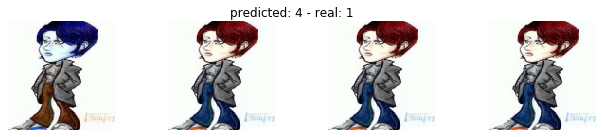

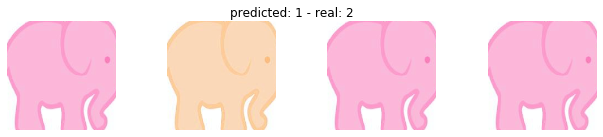

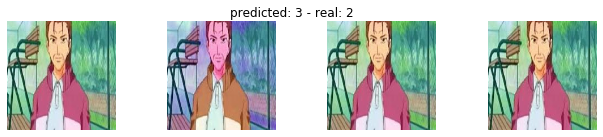

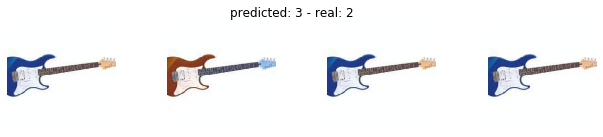

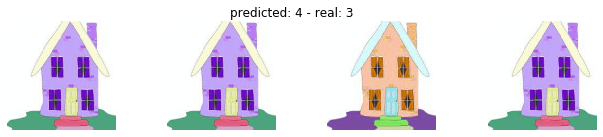

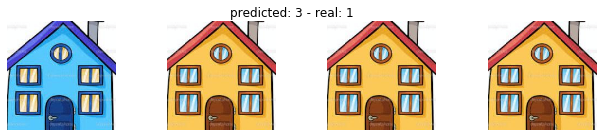

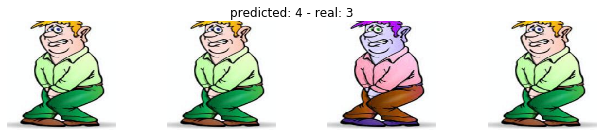

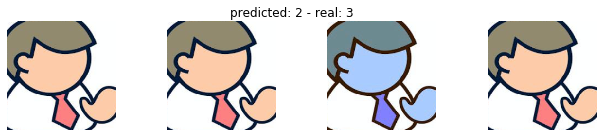

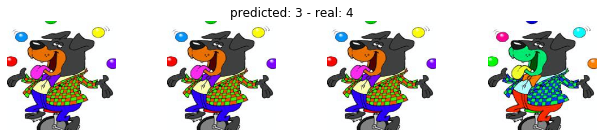

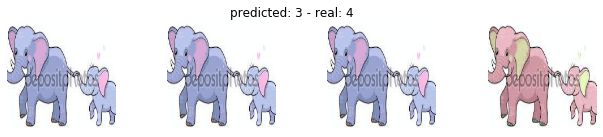

In [0]:
tot_dataloader = DataLoader(dataset=dataset, batch_size=best_BS, shuffle=True, num_workers=4, drop_last=True)
visualize(net,tot_dataloader,num_img)